In [1]:
import os
import sys

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = "cuda"
    print("Cuda loaded.")
else:
    print("No cuda warning!")

Cuda loaded.


In [2]:
# Add the parent directory to sys.path
sys.path.append("..")

from utils import *

In [3]:
# Parameters

LR = 1e-2
NUM_ITER = 1000

In [4]:
# Load data

data_dir = "../data/"

x_train = torch.load(os.path.join(data_dir, 'x_train.pt')).to(device)
y_train = torch.load(os.path.join(data_dir, 'y_train.pt')).to(device)
x_test = torch.load(os.path.join(data_dir, 'x_test.pt')).to(device)
y_test = torch.load(os.path.join(data_dir, 'y_test.pt')).to(device)  # feasible for small moon data

# Cast to dataset

train_data = CastedDataset(x_train, y_train)
# test_dataset = CastedDataset(x_test, y_test)

In [5]:
# Load wstar

FSTAR = LogisticRegression()
FSTAR.load_state_dict(torch.load(os.path.join(data_dir, 'wstar.pt')))

FSTAR.to(device)

WSTAR = torch.cat([param.data.flatten() for param in FSTAR.parameters()])  # for score computation

LogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [6]:
# Init student

student = LogisticRegression()
student.load_state_dict(torch.load(os.path.join(data_dir, 'w0.pt')))

student.to(device)

student_optimizer = torch.optim.SGD(
    student.parameters(),
    lr=LR
)

student_log = Log()

In [7]:
# Evaluate before training

def eval(student, log):

    student.eval()

    w_dist = torch.stack([torch.norm(p1 - p2) ** 2 for p1, p2 in zip(student.parameters(), FSTAR.parameters())]).sum().item()
    train_loss = nn.BCEWithLogitsLoss()(student(x_train), y_train).item()
    test_acc = (((student(x_test) > 0.5) == y_test).sum() / len(y_test)).item()

    log.w_dist.append(w_dist)
    log.train_loss.append(train_loss)
    log.test_acc.append(test_acc)


eval(student, student_log)

In [8]:
def train(num_iter, student, optimizer, log):

    for i in (pbar := tqdm(range(num_iter))):

        # =============== Teacher works ===============
        student.eval()

        grad = torch.autograd.grad(
            nn.BCEWithLogitsLoss(reduction="none")(student(x_train), y_train),
            student.parameters(),
            grad_outputs = torch.eye(len(y_train), device=device),
            is_grads_batched=True
        )  # tuple, for each param, (batch_size, param_shape)

        grad = torch.cat([g.reshape(g.shape[0], -1) for g in grad], dim=1)  # (batch_size, param_shape)

        T1 = torch.sum(grad ** 2, 1)

        w = torch.cat([param.data.flatten() for param in student.parameters()])
        T2 = grad @ (w - WSTAR).squeeze()

        score = LR**2 * T1 - 2 * LR * T2

        idx = torch.argmin(score, keepdim=True)

        x = x_train[idx]
        y = y_train[idx]

        # ========================================

        # Train student
        student.train()

        optimizer.zero_grad()
        loss = nn.BCEWithLogitsLoss()(student(x), y)
        loss.backward()
        optimizer.step()

        # Eval student
        student.eval()

        w_dist = torch.stack([torch.norm(p1 - p2) ** 2 for p1, p2 in zip(student.parameters(), FSTAR.parameters())]).sum().item()
        train_loss = nn.BCEWithLogitsLoss()(student(x_train), y_train).item()
        test_acc = (((student(x_test) > 0.5) == y_test).sum() / len(y_test)).item()

        # Update log
        log.iter += 1
        log.w_dist.append(w_dist)
        log.train_loss.append(train_loss)
        log.test_acc.append(test_acc)

        pbar.set_description(f"Iter {log.iter}, w_dist = {w_dist:.4f}, train loss = {train_loss:.4f}, test acc = {test_acc:.4f}")

In [9]:
train(NUM_ITER, student, student_optimizer, student_log)

Iter 97, w_dist = 3.6402, train loss = 0.3247, test acc = 0.8650:   7%|▋         | 72/1000 [00:00<00:01, 718.10it/s]

Iter 1000, w_dist = 1.3144, train loss = 0.2882, test acc = 0.8800: 100%|██████████| 1000/1000 [00:01<00:00, 717.62it/s]


Text(0, 0.5, 'Test Accuracy')

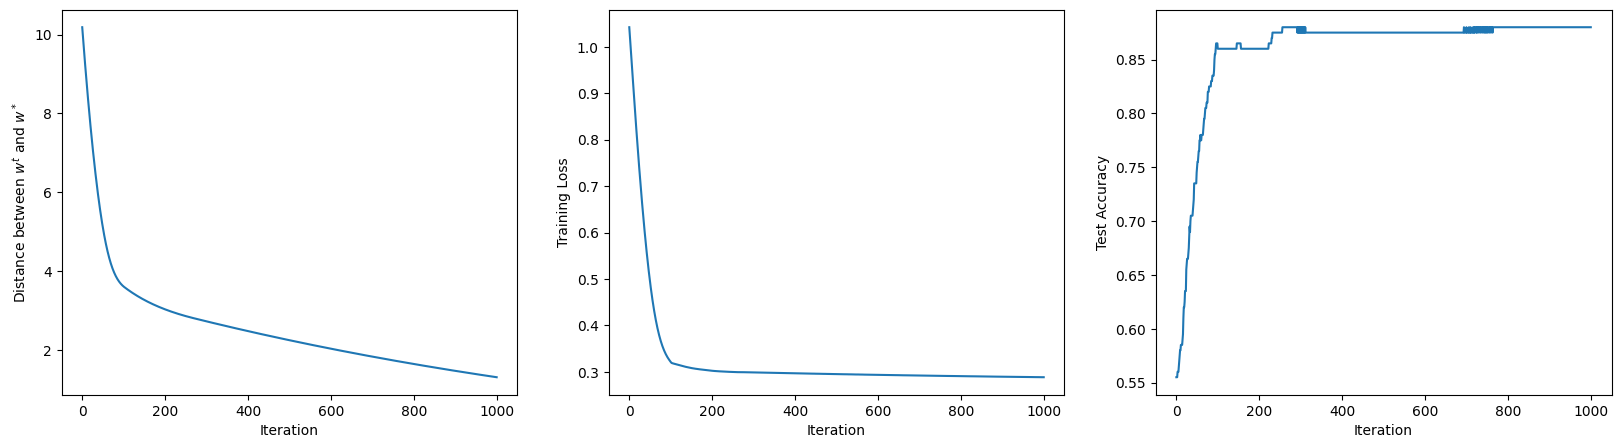

In [10]:
# Plot

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(student_log.w_dist)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel(f"Distance between $w^t$ and $w^*$")

ax[1].plot(student_log.train_loss)
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Training Loss")

ax[2].plot(student_log.test_acc)
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Test Accuracy")

In [11]:
# Save results

results_dir = "../results/"

results = {
    "w": student_log.w_dist,
    "loss": student_log.train_loss,
    "acc": student_log.test_acc
}

np.save(os.path.join(results_dir, 'IMT.npy'), results)